<a href="https://colab.research.google.com/github/cheng1610/movie-sentiment/blob/main/movie_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

size = 20000
maxlen=300

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=size)

word_index = imdb.get_word_index()

# print(word_index['the'])

index_word = {index+3: word for word, index in word_index.items()}
# print(index_word)

index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"


x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


In [2]:
model = Sequential([
    Embedding(input_dim=size, output_dim=128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])


In [3]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [4]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.6750 - loss: 0.5850 - val_accuracy: 0.7888 - val_loss: 0.4697
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.8580 - loss: 0.3498 - val_accuracy: 0.8324 - val_loss: 0.3879
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.9037 - loss: 0.2464 - val_accuracy: 0.8548 - val_loss: 0.3728
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9095 - loss: 0.2316 - val_accuracy: 0.7356 - val_loss: 0.5641
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9141 - loss: 0.2198 - val_accuracy: 0.8382 - val_loss: 0.4216


In [5]:
loss, acc = model.evaluate(x_test, y_test)
print(f"測試集準確率: {acc*100:.2f}%")

782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 123ms/step - accuracy: 0.8292 - loss: 0.4400
測試集準確率: 83.02%


In [6]:
def decode(sequence: str) -> str:
    sequence = [i for i in sequence if i != 0]
    text =  " ".join([index_word.get(i, "?") for i in sequence])
    decoded = text.replace(
            "<START>", ""
        ).replace(
            "<UNK>", "something"
        ).replace(
            "br br", ",\n"
        )
    return decoded.strip()

In [7]:
from dataclasses import dataclass
from typing import List, Literal, Union

@dataclass
class ConvertResult:
    token: List[int]
    decode: str
    evaluation: Union[Literal['負評'], Literal['正評']]


In [12]:
def test(test_size: int, _print: bool = True) -> list[ConvertResult]:
    pre = x_test[:test_size]

    pred = model.predict(pre)
    pred_labels = (pred > 0.5).astype(int)

    label_map = {0: "負評", 1: "正評"}
    pred_texts = [label_map[i[0]] for i in pred_labels]

    y= [label_map[i] for i in list(y_test[:test_size])]

    results = []

    for idx, (seq, pred_label) in enumerate(zip(pre, pred_texts), start=1):
        decoded_text = decode(seq)
        if decoded_text.endswith(","):
            continue

        if _print:
            print(f"文字內容{idx}:\n{decoded_text}")
            print(f"預測評價: {pred_label}, 真實評價: {y[idx-1]}\n")

        results.append(
            ConvertResult(
                token=seq,
                decode=decoded_text,
                evaluation=pred_label
            )
        )

    return results


In [13]:
size = 5
res = test(size, True)
# print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
文字內容1:
please give this one a miss ,
 kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat ,
 i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss
預測評價: 負評, 真實評價: 負評

文字內容2:
this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax ,
 the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilli

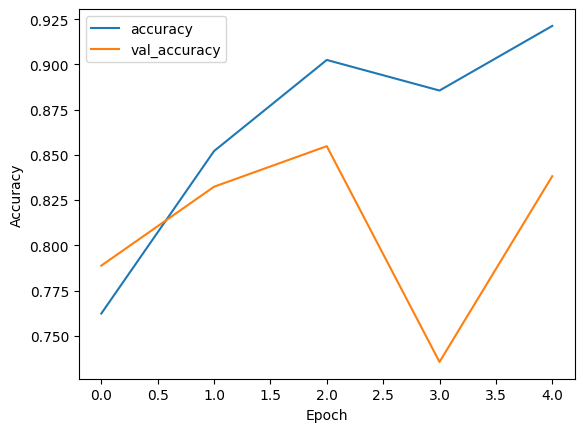

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
